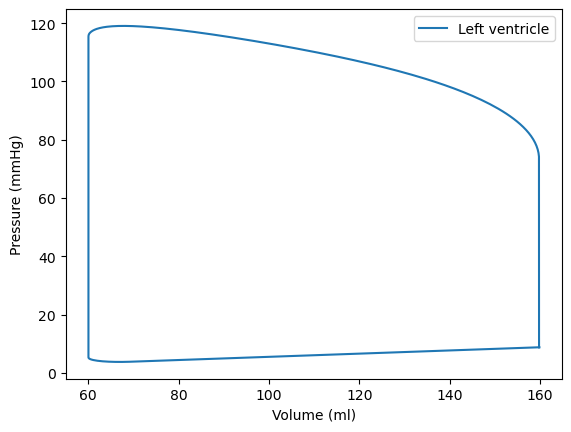

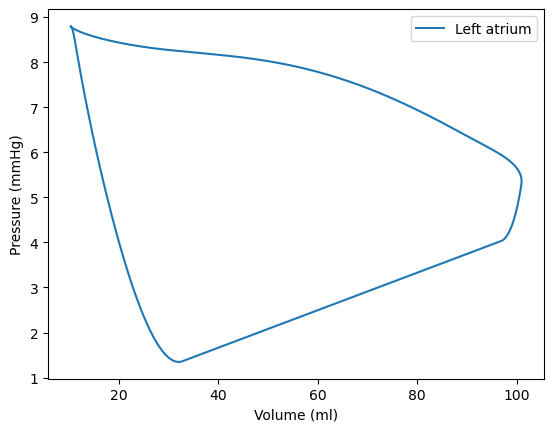

In [13]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Define parameters
E_max_lv = 1.9326 # Maximal elastance of left ventricle
E_min_lv = 0.0548 # Minimal elastance of left ventricle
E_max_la = 0.8567  # Maximal elastance of left atrium
E_min_la = 0.0416  # Minimal elastance of left atrium

T_es_v = 0.3 # End systolic time of ventricle
T_ep_v= 0.5 # End pulse time of ventricle
T_ep_a = 0.1 # End pulse time of atrium
T_bs_a = 0.45 # Beginning of systolic time of atrium
T_es_a = 0.9 # End systolic time of atrium
T_cycle = 1.0 # Cardiac cycle time

Z_ao = 0.0144 # Aortic valve resistance
R_mv = 0.0030 # Mitral valve resistance

R_s = 0.8640 # Systemic resistance
R_sv = 0.0320 # Systemic venous resistance
C_sa = 1.7986 # Systemic arterial compliance
C_sv = 30.1297 # Systemic venous compliance
# Define the elastance function for ventricle
def elastance_v(T, E_max, E_min):
    t = T % T_cycle
    if t < T_es_v:
        return (E_max - E_min) * 0.5 * (1 - np.cos(np.pi * t / T_es_v)) + E_min
    elif t < T_ep_v:
        return (E_max - E_min) * 0.5 * (1 + np.cos(np.pi * (t - T_es_v) / (T_ep_v - T_es_v))) + E_min
    else:
        return E_min

# Define the elastance function for atrium
def elastance_a(T, E_max, E_min):
    t = T % T_cycle
    if t < T_ep_a:
        return (E_max - E_min) * 0.5 * (1 - np.cos(np.pi * (t - T_ep_a) / (T_cycle - T_es_a + T_ep_a))) + E_min
    elif t < T_bs_a:
        return E_min
    elif t < T_es_a:
        return (E_max - E_min) * 0.5 * (1 - np.cos(np.pi * (t - T_bs_a) / (T_es_a - T_bs_a))) + E_min
    else:
        return (E_max - E_min) * 0.5 * (1 + np.cos(np.pi * (t - T_es_a) / (T_cycle - T_es_a + T_ep_a))) + E_min
    

# Define the valve flow function
def valve(P_in, P_out, R):
    if P_in > P_out:
        q = (P_in - P_out) / R
    else:
        q = 0.0
    return q

# Define the system of ODEs
def model(t, y):
    V_lv = y[0] # Left ventricular volume
    V_la = y[1] # Left atrial volume
    V_sa = y[2] # Systemic arterial pressure
    V_sv = y[3] # Systemic venous pressure

    # Pressures
    P_lv = elastance_v(t, E_max_lv, E_min_lv) * V_lv # Left ventricular pressure
    P_la = elastance_a(t, E_max_la, E_min_la) * V_la # Left atrial pressure
    P_sa = V_sa / C_sa # Systemic arterial pressure
    P_sv = V_sv / C_sv # Systemic venous pressure

    # Flow rates
    Q_sa = valve(P_lv, P_sa, Z_ao) # Systemic arterial (AO) flow
    Q_sv = (P_sa - P_sv) / R_s # Systemic venous flow
    Q_la = (P_sv - P_la) / R_sv # Left atrial flow
    Q_lv = valve(P_la, P_lv, R_mv) # Left ventricular (MV) flow

    # Equations for variables         
    dV_lv_dt = Q_lv - Q_sa
    dV_la_dt = Q_la - Q_lv
    dV_sa_dt = Q_sa - Q_sv
    dV_sv_dt = Q_sv - Q_la


    return [dV_lv_dt, dV_la_dt, dV_sa_dt, dV_sv_dt]

# Initial conditions for left ventricle, left atrium, systemic arterial pressure, and systemic venous pressure
y0 = [146, 48.1, 167.2, 240.1]

# Time span and solve the ODE
t_span = (0* T_cycle, 5 * T_cycle)
t_eval = np.linspace(*t_span, 5000)

sol = solve_ivp(model, t_span, y0, t_eval=t_eval, rtol=1e-8, atol=1e-8)
P_lv = [elastance_v(t, E_max_lv, E_min_lv) * V for t, V in zip(sol.t, sol.y[0])]
P_lv = np.array(P_lv)
P_la = [elastance_a(t, E_max_la, E_min_la) * V for t, V in zip(sol.t, sol.y[1])]
P_la = np.array(P_la)
# Plot the results
time_selection = (sol.t >= 4 * T_cycle) & (sol.t <= 5 * T_cycle)
index = np.where(time_selection)
selected_times = sol.t[index]

# Plot volume-pressure loops for the ventricles in the last cardiac cycle
# Plot volume-pressure loops for the ventricles in the last cardiac cycle
plt.figure()
plt.plot(sol.y[0][index], P_lv[index], label='Left ventricle')
plt.xlabel('Volume (ml)')
plt.ylabel('Pressure (mmHg)')
plt.legend()

# Plot volume-pressure loops for the atria in the last cardiac cycle
plt.figure()
plt.plot(sol.y[1][index], P_la[index], label='Left atrium')
plt.xlabel('Volume (ml)')
plt.ylabel('Pressure (mmHg)')
plt.legend()

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from SALib.sample import sobol as sobol_sample
from SALib.analyze import sobol

# Define parameters
# E_max_lv = 1.9326 # Maximal elastance of left ventricle
# E_min_lv = 0.0548 # Minimal elastance of left ventricle
# E_max_la = 0.8567  # Maximal elastance of left atrium
# E_min_la = 0.0416  # Minimal elastance of left atrium

# T_es_v = 0.3 # End systolic time of ventricle
# T_ep_v= 0.5 # End pulse time of ventricle
# T_ep_a = 0.1 # End pulse time of atrium
# T_bs_a = 0.45 # Beginning of systolic time of atrium
# T_es_a = 0.9 # End systolic time of atrium
T_cycle = 1.0 # Cardiac cycle time

# Z_ao = 0.0144 # Aortic valve resistance
# R_mv = 0.0030 # Mitral valve resistance

# R_s = 0.8640 # Systemic resistance
# R_sv = 0.0320 # Systemic venous resistance
# C_sa = 1.7986 # Systemic arterial compliance
# C_sv = 30.1297 # Systemic venous compliance


# Define the elastance function for ventricle
def elastance_v(T, E_max, E_min, T_es_v, T_ep_v):
    t = T % T_cycle
    if t < T_es_v:
        return (E_max - E_min) * 0.5 * (1 - np.cos(np.pi * t / T_es_v)) + E_min
    elif t < T_ep_v:
        return (E_max - E_min) * 0.5 * (1 + np.cos(np.pi * (t - T_es_v) / (T_ep_v - T_es_v))) + E_min
    else:
        return E_min


# Define the elastance function for atrium
def elastance_a(T, E_max, E_min, T_ep_a, T_bs_a, T_es_a):
    t = T % T_cycle
    if t < T_ep_a:
        return (E_max - E_min) * 0.5 * (1 - np.cos(np.pi * (t - T_ep_a) / (T_cycle - T_es_a + T_ep_a))) + E_min
    elif t < T_bs_a:
        return E_min
    elif t < T_es_a:
        return (E_max - E_min) * 0.5 * (1 - np.cos(np.pi * (t - T_bs_a) / (T_es_a - T_bs_a))) + E_min
    else:
        return (E_max - E_min) * 0.5 * (1 + np.cos(np.pi * (t - T_es_a) / (T_cycle - T_es_a + T_ep_a))) + E_min
    

# Define the valve flow functions
def valve(P_in, P_out, R):
    if P_in > P_out:
        q = (P_in - P_out) / R
    else:
        q = 0.0
    return q


def model(t, y, E_max_lv, E_min_lv, E_max_la, E_min_la, T_es_v, T_ep_v, T_ep_a, T_bs_a, T_es_a, Z_ao, R_mv, R_s, R_sv, C_sa, C_sv):
    V_lv = y[0] # Left ventricular volume
    V_la = y[1] # Left atrial volume
    V_sa = y[2] # Systemic arterial pressure
    V_sv = y[3] # Systemic venous pressure

    # Pressures
    P_lv = elastance_v(t, E_max_lv, E_min_lv, T_es_v, T_ep_v) * V_lv # Left ventricular pressure
    P_la = elastance_a(t, E_max_la, E_min_la, T_ep_a, T_bs_a, T_es_a) * V_la # Left atrial pressure
    P_sa = V_sa / C_sa # Systemic arterial pressure
    P_sv = V_sv / C_sv # Systemic venous pressure

    # Flow rates
    Q_sa = valve(P_lv, P_sa, Z_ao) # Systemic arterial (AO) flow
    Q_sv = (P_sa - P_sv) / R_s # Systemic venous flow
    Q_la = (P_sv - P_la) / R_sv # Left atrial flow
    Q_lv = valve(P_la, P_lv, R_mv) # Left ventricular (MV) flow

    # Equations for variables         
    dV_lv_dt = Q_lv - Q_sa
    dV_la_dt = Q_la - Q_lv
    dV_sa_dt = Q_sa - Q_sv
    dV_sv_dt = Q_sv - Q_la


    return [dV_lv_dt, dV_la_dt, dV_sa_dt, dV_sv_dt]

# Initial conditions
y0 = [146, 48.1, 167.2, 241.1]


# Time span
t_span = (0* T_cycle, 5 * T_cycle)
t_eval = np.linspace(*t_span, 500)

baseline_params = {
    'E_max_lv': 1.9326, 'E_min_lv': 0.0548, 'E_max_la': 0.8567, 'E_min_la': 0.0416,
    'T_es_v': 0.3, 'T_ep_v': 0.5, 'T_ep_a': 0.1, 'T_bs_a': 0.45, 'T_es_a': 0.9,
    'Z_ao': 0.0144, 'R_mv': 0.0030, 'R_s': 0.8640, 'R_sv': 0.0320, 'C_sa': 1.7986, 'C_sv': 30.1297
}

percentage_range = 0.05 # ±2%

bounds = [[(1 - percentage_range) * value, (1 + percentage_range) * value] for value in baseline_params.values()]


# Define the problem for the sensitivity analysis
problem = {
    'num_vars': 15,
    'names': ['E_max_lv', 'E_min_lv', 'E_max_la', 'E_min_la', 'T_es_v', 'T_ep_v', 'T_ep_a', 'T_bs_a', 'T_es_a', 'Z_ao', 'R_mv', 'R_s', 'R_sv', 'C_sa', 'C_sv'],
    'bounds': bounds}

# Generate samples
param_values = sobol_sample.sample(problem, 50000)

# Run the model for each sample
outputs = []
# For this example, outputs is the value of Systemic arterial pressure at time index 50
for params in param_values:
    sol = solve_ivp(model, t_span, y0, t_eval = t_eval, method= 'RK45', args = (params[0], params[1], params[2], params[3], params[4], params[5], params[6], params[7], params[8],
                                                                                params[9], params[10], params[11], params[12], params[13], params[14]))

    variance_output = np.var(sol.y[2, :])
    outputs.append(variance_output)
    
print(param_values.shape)
print(np.array(outputs).shape)

# Perform the sensitivity analysis
Si = sobol.analyze(problem, np.array(outputs))

# Print the first-order indices
print(Si['S1'])

# Print the total indices
print(Si['ST'])




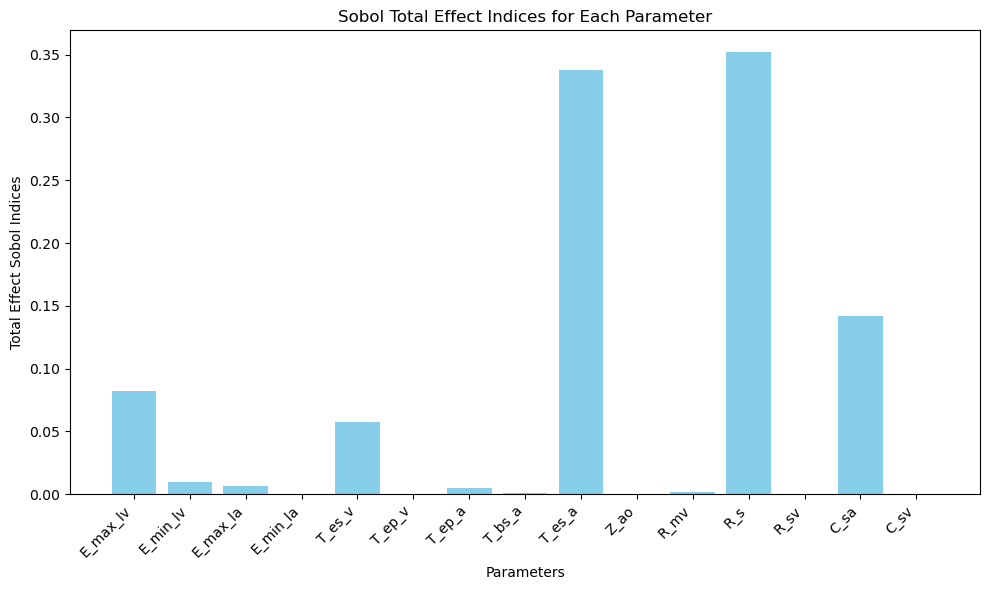

In [ ]:
param_names = ['E_max_lv', 'E_min_lv', 'E_max_la', 'E_min_la', 'T_es_v', 'T_ep_v', 'T_ep_a', 'T_bs_a', 'T_es_a', 'Z_ao', 'R_mv', 'R_s', 'R_sv', 'C_sa', 'C_sv']

plt.figure(figsize=(10, 6))
plt.bar(param_names, Si['S1'], color='skyblue')
plt.xlabel('Parameters')
plt.ylabel('Total Effect Sobol Indices')
plt.title('Sobol Total Effect Indices for Each Parameter')
plt.xticks(rotation=45, ha='right') 
plt.tight_layout()  
plt.show()

In [2]:
import numpy as np
from scipy.integrate import solve_ivp
from SALib.sample import sobol as sobol_sample
from SALib.analyze import sobol

# Define the cardiac cycle time
T_cycle = 1.0

# Elastance functions
def elastance_v(T, E_max, E_min, T_es_v, T_ep_v):
    t = T % T_cycle
    if t < T_es_v:
        return (E_max - E_min) * 0.5 * (1 - np.cos(np.pi * t / T_es_v)) + E_min
    elif t < T_ep_v:
        return (E_max - E_min) * 0.5 * (1 + np.cos(np.pi * (t - T_es_v) / (T_ep_v - T_es_v))) + E_min
    return E_min

def elastance_a(T, E_max, E_min, T_ep_a, T_bs_a, T_es_a):
    t = T % T_cycle
    if t < T_ep_a:
        return (E_max - E_min) * 0.5 * (1 - np.cos(np.pi * (t - T_ep_a) / (T_cycle - T_es_a + T_ep_a))) + E_min
    elif t < T_bs_a:
        return E_min
    elif t < T_es_a:
        return (E_max - E_min) * 0.5 * (1 - np.cos(np.pi * (t - T_bs_a) / (T_es_a - T_bs_a))) + E_min
    return (E_max - E_min) * 0.5 * (1 + np.cos(np.pi * (t - T_es_a) / (T_cycle - T_es_a + T_ep_a))) + E_min

def valve(P_in, P_out, R):
    return (P_in - P_out) / R if P_in > P_out else 0.0

# Heart model
def model(t, y, *params):
    E_max_lv, E_min_lv, E_max_la, E_min_la, T_es_v, T_ep_v, T_ep_a, T_bs_a, T_es_a, Z_ao, R_mv, R_s, R_sv, C_sa, C_sv = params
    V_lv, V_la, V_sa, V_sv = y
    P_lv = elastance_v(t, E_max_lv, E_min_lv, T_es_v, T_ep_v) * V_lv
    P_la = elastance_a(t, E_max_la, E_min_la, T_ep_a, T_bs_a, T_es_a) * V_la
    P_sa = V_sa / C_sa
    P_sv = V_sv / C_sv
    Q_sa = valve(P_lv, P_sa, Z_ao)
    Q_sv = valve(P_sa, P_sv, R_s)
    Q_la = valve(P_sv, P_la, R_sv)
    Q_lv = valve(P_la, P_lv, R_mv)
    return [Q_lv - Q_sa, Q_la - Q_lv, Q_sa - Q_sv, Q_sv - Q_la]

# Initial conditions and time span
y0 = [146, 48.1, 167.2, 241.1]
t_span = (0, 5 * T_cycle)
t_eval = np.linspace(*t_span, 500)

# Parameter setup for sensitivity analysis
baseline_params = {
    'E_max_lv': 1.9326, 'E_min_lv': 0.0548, 'E_max_la': 0.8567, 'E_min_la': 0.0416,
    'T_es_v': 0.3, 'T_ep_v': 0.5, 'T_ep_a': 0.1, 'T_bs_a': 0.45, 'T_es_a': 0.9,
    'Z_ao': 0.0144, 'R_mv': 0.0030, 'R_s': 0.8640, 'R_sv': 0.0320, 'C_sa': 1.7986, 'C_sv': 30.1297
}
percentage_range = 0.02  # ±5%
bounds = [[(1 - percentage_range) * value, (1 + percentage_range) * value] for value in baseline_params.values()]

problem = {
    'num_vars': 15,
    'names': list(baseline_params.keys()),
    'bounds': bounds
}

# Sampling
param_values = sobol_sample.sample(problem, 10000)

# Simulation and data collection for sensitivity analysis
outputs = np.zeros((len(param_values), 3))  # Three outputs: LV, LA, SA variances
for idx, params in enumerate(param_values):
    sol = solve_ivp(model, t_span, y0, t_eval=t_eval, method='RK45', args=params)
    if sol.success:
        outputs[idx, 0] = np.var(sol.y[0])
        outputs[idx, 1] = np.var(sol.y[1])
        outputs[idx, 2] = np.var(sol.y[2]/params[13])

# Sensitivity analysis
Si = [sobol.analyze(problem, outputs[:, i], calc_second_order=True) for i in range(3)]

# Printing results
for i, name in enumerate(['Left Ventricle', 'Left Atrium', 'Systemic Arterial']):
    print(f"Sensitivity Indices for {name}:")
    print("First-order indices:", Si[i]['S1'])
    print("Total indices:", Si[i]['ST'])




/Users/pantalone/anaconda3/lib/python3.11/site-packages/scipy/stats/_qmc.py:804: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


Sensitivity Indices for Left Ventricle:
First-order indices: [ 8.52580006e-02  1.13468097e-01  1.22507733e-04  1.28920277e-02
  2.86681611e-02  1.84405539e-02  1.24763058e-03  1.33384663e-01
  2.03693378e-02 -2.95572893e-04 -2.35159150e-05  1.81189963e-01
  3.01657350e-02  3.45820620e-02  3.40079380e-01]
Total indices: [0.08647349 0.1144654  0.00135405 0.01420123 0.02962834 0.01897901
 0.00215646 0.13504581 0.02209557 0.00128335 0.00139033 0.18204219
 0.03211648 0.03506947 0.34172284]
Sensitivity Indices for Left Atrium:
First-order indices: [ 0.0005301   0.01563295  0.00050584  0.05025908  0.00053106  0.08218879
  0.00855149  0.08409018  0.29564349 -0.0003154   0.00122226  0.03439116
  0.18777797  0.04091331  0.19977198]
Total indices: [0.00231177 0.0178755  0.00267863 0.05194255 0.0023463  0.08276289
 0.01070479 0.08638022 0.29773652 0.00213794 0.00363004 0.03673631
 0.18965902 0.0425081  0.20249431]
Sensitivity Indices for Systemic Arterial:
First-order indices: [ 2.64709312e-02  3.

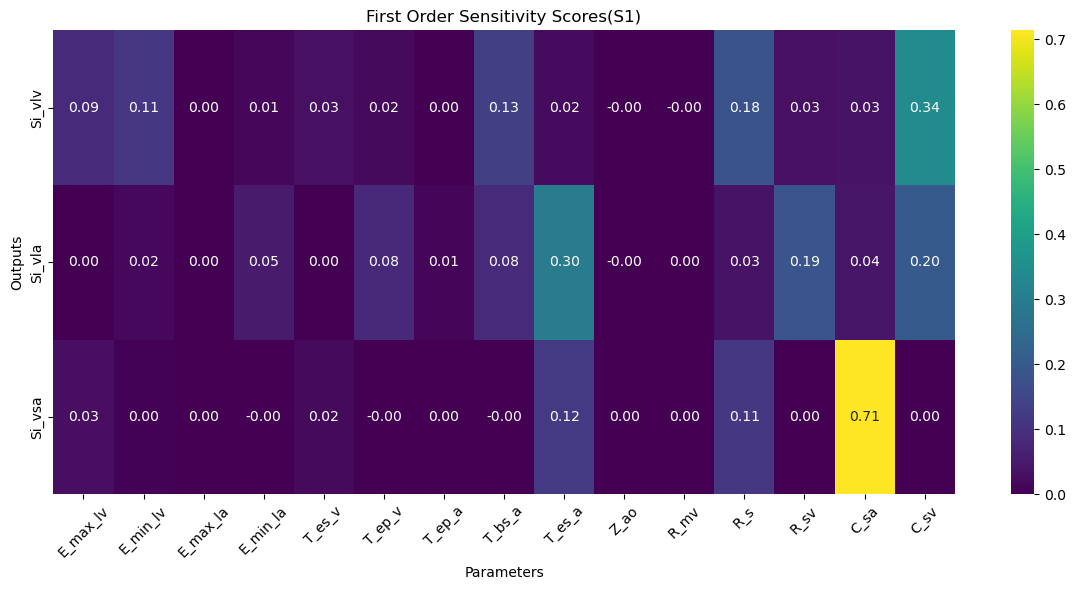

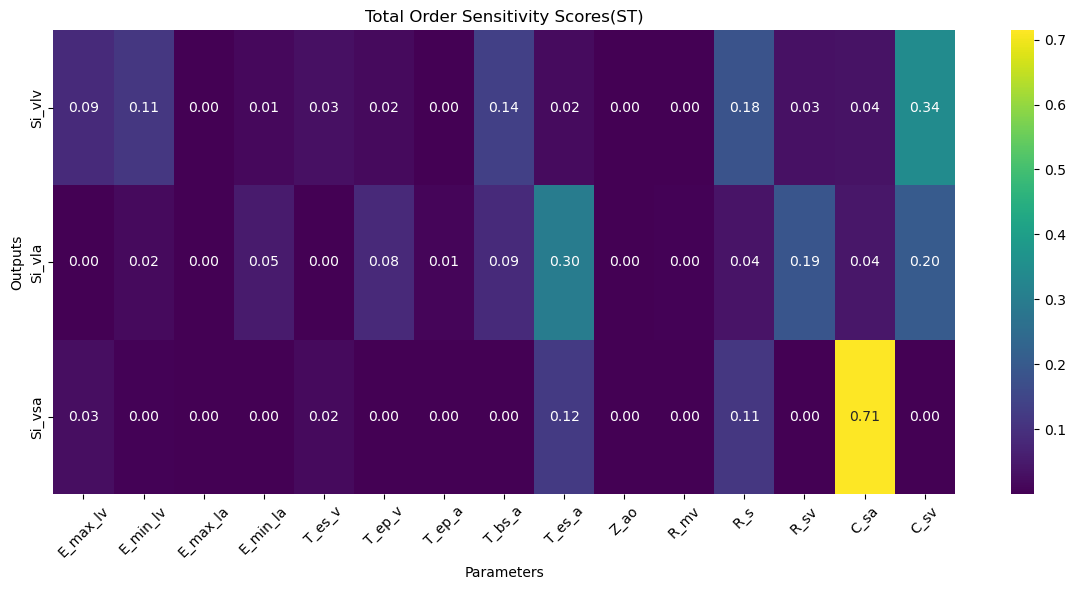

In [3]:
import seaborn as sns
Si_vlv_S1 = Si[0]['S1']
Si_vla_S1 = Si[1]['S1']
Si_vsa_S1 = Si[2]['S1']

# Create a heatmap using seaborn
params_names = problem['names']
heatmap_data = np.array([Si_vlv_S1, Si_vla_S1, Si_vsa_S1])
heatmap_labels = ['Si_vlv', 'Si_vla', 'Si_vsa']

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", xticklabels=params_names, yticklabels=heatmap_labels, cmap='viridis', cbar=True)
plt.title('First Order Sensitivity Scores(S1)')
plt.xlabel('Parameters')
plt.ylabel('Outputs')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Si_vlv_ST = Si[0]['ST']
Si_vla_ST = Si[1]['ST']
Si_vsa_ST = Si[2]['ST']

# Create a heatmap using seaborn
params_names = problem['names']
heatmap_data = np.array([Si_vlv_ST, Si_vla_ST, Si_vsa_ST])
heatmap_labels = ['Si_vlv', 'Si_vla', 'Si_vsa']

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", xticklabels=params_names, yticklabels=heatmap_labels, cmap='viridis', cbar=True)
plt.title('Total Order Sensitivity Scores(ST)')
plt.xlabel('Parameters')
plt.ylabel('Outputs')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

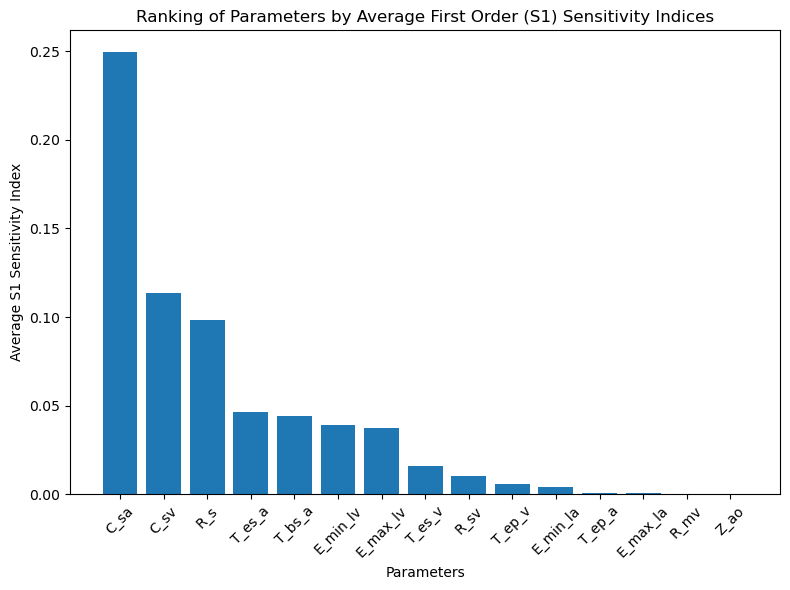

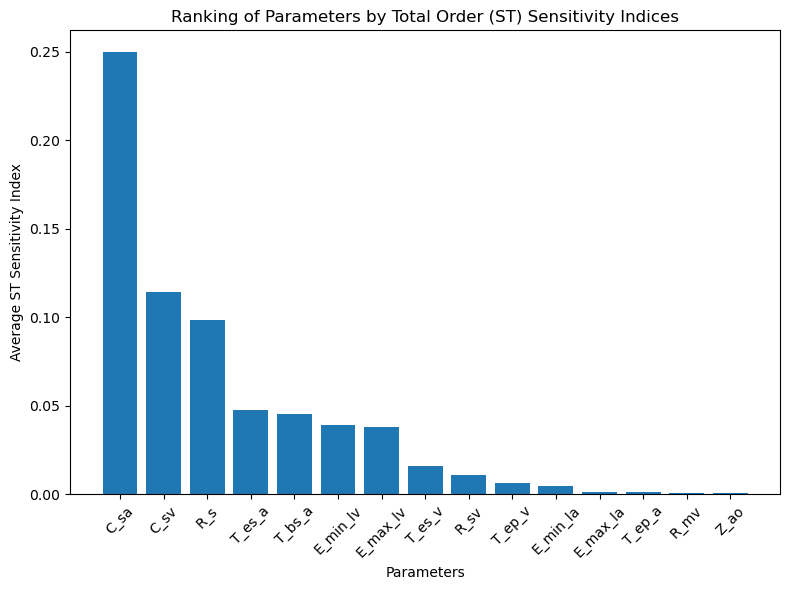

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# 假设Si包含了所有的敏感性分析结果
Si_vlv_S1 = Si[0]['S1']
Si_vsa_S1 = Si[2]['S1']

Si_vlv_ST = Si[0]['ST']
Si_vsa_ST = Si[2]['ST']

# 计算S1和ST的平均值
average_S1 = (Si_vlv_S1 + Si_vsa_S1) / 3
average_ST = (Si_vlv_ST + Si_vsa_ST) / 3

# 获取参数名称
params_names = problem['names']

# 对S1和ST分别排序
sorted_indices_S1 = np.argsort(average_S1)[::-1]  # 降序排序
sorted_indices_ST = np.argsort(average_ST)[::-1]  # 降序排序

sorted_params_S1 = np.array(params_names)[sorted_indices_S1]
sorted_scores_S1 = average_S1[sorted_indices_S1]

sorted_params_ST = np.array(params_names)[sorted_indices_ST]
sorted_scores_ST = average_ST[sorted_indices_ST]

# 绘制S1的条形图
plt.figure(figsize=(8, 6))
plt.bar(sorted_params_S1, sorted_scores_S1)
plt.title('Ranking of Parameters by Average First Order (S1) Sensitivity Indices')
plt.xlabel('Parameters')
plt.ylabel('Average S1 Sensitivity Index')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 绘制ST的条形图
plt.figure(figsize=(8, 6))
plt.bar(sorted_params_ST, sorted_scores_ST)
plt.title('Ranking of Parameters by Total Order (ST) Sensitivity Indices')
plt.xlabel('Parameters')
plt.ylabel('Average ST Sensitivity Index')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from SALib.sample import sobol as sobol_sample
from SALib.analyze import sobol

# Define the cardiac cycle time
T_cycle = 1.0

# Elastance functions
def elastance_v(T, E_max, E_min, T_es_v, T_ep_v):
    t = T % T_cycle
    if t < T_es_v:
        return (E_max - E_min) * 0.5 * (1 - np.cos(np.pi * t / T_es_v)) + E_min
    elif t < T_ep_v:
        return (E_max - E_min) * 0.5 * (1 + np.cos(np.pi * (t - T_es_v) / (T_ep_v - T_es_v))) + E_min
    return E_min

def elastance_a(T, E_max, E_min, T_ep_a, T_bs_a, T_es_a):
    t = T % T_cycle
    if t < T_ep_a:
        return (E_max - E_min) * 0.5 * (1 - np.cos(np.pi * (t - T_ep_a) / (T_cycle - T_es_a + T_ep_a))) + E_min
    elif t < T_bs_a:
        return E_min
    elif t < T_es_a:
        return (E_max - E_min) * (1 - np.cos(np.pi * (t - T_bs_a) / (T_es_a - T_bs_a))) + E_min
    return (E_max - E_min) * 0.5 * (1 + np.cos(np.pi * (t - T_es_a) / (T_cycle - T_es_a + T_ep_a))) + E_min

def valve(P_in, P_out, R):
    return (P_in - P_out) / R if P_in > P_out else 0.0

# Heart model
def model(t, y, *params):
    E_max_lv, E_min_lv, E_max_la, E_min_la, T_es_v, T_ep_v, T_ep_a, T_bs_a, T_es_a, Z_ao, R_mv, R_s, R_sv, C_sa, C_cv = params
    V_lv, V_la, V_sa, V_sv = y
    P_lv = elastance_v(t, E_max_lv, E_min_lv, T_es_v, T_ep_v) * V_lv
    P_la = elastance_a(t, E_max_la, E_min_la, T_ep_a, T_bs_a, T_es_a) * V_la
    P_sa = V_sa / C_sa
    P_sv = V_sv / C_cv
    Q_sa = valve(P_lv, P_sa, Z_ao)
    Q_sv = valve(P_sa, P_sv, R_s)
    Q_la = valve(P_sv, P_la, R_sv)
    Q_lv = valve(P_la, P_lv, R_mv)
    return [Q_lv - Q_sa, Q_la - Q_lv, Q_sa - Q_sv, Q_sv - Q_la]

# Initial conditions and time span
y0 = [146, 48.1, 167.2, 241.1]
t_span = (0, 5 * T_cycle)
t_eval = np.linspace(*t_span, 500)

# Parameter setup for sensitivity analysis
baseline_params = {
    'E_max_lv': 1.9326, 'E_min_lv': 0.0548, 'E_max_la': 0.8567, 'E_min_la': 0.0416,
    'T_es_v': 0.3, 'T_ep_v': 0.5, 'T_ep_a': 0.1, 'T_bs_a': 0.45, 'T_es_a': 0.9,
    'Z_ao': 0.0144, 'R_mv': 0.0030, 'R_s': 0.8640, 'R_sv': 0.0320, 'C_sa': 1.7986, 'C_cv': 30.1297
}
percentage_range = 0.02
bounds = [[(1 - percentage_range) * value, (1 + percentage_range) * value] for value in baseline_params.values()]

problem = {
    'num_vars': 15,
    'names': list(baseline_params.keys()),
    'bounds': bounds
}

# Sample sizes to test
sample_sizes = [100, 500, 1000, 2000, 3000, 4000, 5000]
S1_scores_list = []
ST_scores_list = []

# Calculate S1 and ST scores for each sample size
for sample_size in sample_sizes:
    param_values = sobol_sample.sample(problem, sample_size, calc_second_order=True)
    outputs = np.zeros((len(param_values), 3))  # Three outputs: LV, LA, SA variances
    for idx, params in enumerate(param_values):
        sol = solve_ivp(model, t_span, y0, t_eval=t_eval, method='RK45', args=params)
        if sol.success:
            outputs[idx, 0] = np.var(sol.y[0, :])
            outputs[idx, 1] = np.var(sol.y[1, :])
            outputs[idx, 2] = np.var(sol.y[2]/params[13])
    Si = [sobol.analyze(problem, outputs[:, i], calc_second_order=True) for i in range(3)]
    S1_scores_list.append([Si[j]['S1'] for j in range(3)])
    ST_scores_list.append([Si[j]['ST'] for j in range(3)])

# Plot the convergence of S1 scores
S1_scores_array = np.array(S1_scores_list)
ST_scores_array = np.array(ST_scores_list)
for j, name in enumerate(['Left Ventricle', 'Left Atrium', 'Systemic Arterial']):
    plt.figure(figsize=(10, 6))
    for i in range(problem['num_vars']):
        plt.plot(sample_sizes, S1_scores_array[:, j, i], marker='o', label=problem['names'][i])
    plt.title(f"Convergence of S1 scores for {name}")
    plt.xlabel("Sample Size")
    plt.ylabel("S1 score")
    plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 6))
    for i in range(problem['num_vars']):
        plt.plot(sample_sizes, ST_scores_array[:, j, i], marker='o', label=problem['names'][i])
    plt.title(f"Convergence of ST scores for {name}")
    plt.xlabel("Sample Size")
    plt.ylabel("ST score")
    plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
    plt.tight_layout()
    plt.show()
